Here the questions that were asked in the ReadMe are processed. 

**This is only a starting point, as all analyses can be further improved and expanded.**
 
For example, topic extraction methods can improve the word clouds, the LightGBM for predicting prices can be tuned even better, and further measures against overfitting can be taken, such as subsampling, bagging, and boosting. Modeling and data analysis is an iterative process. Therefore, please consider this Notbook as an initial start.

Please feel free to complement, expand and improve this notebook!

### Getting started...

In this notebook I want to address some questions about the berlin Airbnb data set. 

At first, let's load the data:

In [72]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# libraries fpr price prediction
import lightgbm as lgb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_squared_error
from lightgbm.callback import early_stopping



# NLP libraries for word cloud calculation 
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud

# filter the text on language
from langdetect import detect, LangDetectException


# libraries for map
import geopandas as gpd
import folium

from IPython.display import display
import matplotlib




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\franz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load the data...

In [73]:
# path 
geo_path = 'C:/Users/franz/Documents/udacity/scripts/ud_course/'
data_path = 'C:/Users/franz/Documents/udacity/Data/berlin/'

listings = pd.read_csv(data_path + "listings.csv")
calendar = pd.read_csv(data_path + "calendar.csv")
reviews = pd.read_csv(data_path + "reviews.csv")

# Data preprocessing

## We start with the listings data:

- To create the wordcloud for each neighborhood we need descriptions of the neighborhood, which are stored in the 'neighborhood_overview' column. However, this column is filled only a little more than 50%. Nevertheless, there are a total of almost 6000 descriptions, so that a good description of the neighborhoods should be possible. The unfilled descriptions must be replaced with an empty string. 
- The Dollar sign needs to be removed from the 'price' column. 
- % sign needs to be replaced from  'host_response_rate'
- Replace nas in  'host_response_time' with unknown and in 'host_response_rate' with -1.

In [74]:

print(f"Length of listings data before preprocessing: {len(listings)} ")


# count nas for neighborhood_overview and replace nas with empty string
na_perc_neighborhood_overview = (listings['neighborhood_overview'].isnull().sum() / len(listings)) *100
print(f"NaN values in column 'neighborhood_overview': {na_perc_neighborhood_overview} %")
listings.neighborhood_overview =listings.neighborhood_overview.fillna(' ')

# drop if no price available
listings = listings.dropna(subset=["price"])


# Replace the dollar sign in the price column
def removeDollar(df,column):
    """removes Dollar sign from a column and convert the column to numeric

    Args:
        df (DataFrame): DataFrame with column 'column'
        column (str): Name of the column being edited

    Returns:
        DataFrame: DataFrame with $ removed from column 'column'
    """
    df[column] = df[column].str.replace('$', '')
    df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

listings = removeDollar(listings,"price")


# Replace the % sign in the host response rate column
listings.host_response_rate = listings.host_response_rate.str.replace('%', '').astype(float)

#drop if host_response_time or host_response_rate are missing
na_count = listings['host_response_time'].isna() | listings['host_response_rate'].isna()
total_na_count = na_count.sum()
na_perc_host_response = (total_na_count / len(listings)) *100
print(f"NaN values in column 'host_response_time' or 'host_response_rate': {na_perc_host_response} %")

listings.host_response_time = listings.host_response_time.fillna('unknown') 
listings.host_response_rate = listings.host_response_rate.fillna(-1)

# for wordclouds:
descriptions = listings[listings['neighborhood_overview'] != ' ']['neighborhood_overview']
neighborhoods = listings[listings['neighborhood_overview'] != ' ']['neighbourhood_group_cleansed'] 

print(f"Length of listings data after preprocessing: {len(listings)} ")



Length of listings data before preprocessing: 12472 
NaN values in column 'neighborhood_overview': 46.96119307248236 %
NaN values in column 'host_response_time' or 'host_response_rate': 39.14368184733804 %
Length of listings data after preprocessing: 12472 


C:\Users\franz\AppData\Local\Temp\ipykernel_22136\3718423718.py:24: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column] = df[column].str.replace('$', '')


In [75]:
type(listings)

pandas.core.frame.DataFrame

## Now, let's look at the review data:

- To create the wordcloud for each neighborhood we need reviews of the neighborhood, which are stored in the 'comments' column. This is in less than 1% of the values the case. The unfilled comments must be replaced with an empty string. 

In [76]:
print(f"Length of reviews data before preprocessing: {len(reviews)} ")


# if no comment fill with empty string
na_perc_comments = (reviews['comments'].isnull().sum() / len(reviews)) *100
print(f"NaN values in column 'comments': {na_perc_comments} %")
reviews.comments = reviews.comments.fillna(' ')

# merge reviews and listings for anaylsis
reviews_neighborhood = reviews.merge(listings[['id','neighbourhood_group_cleansed']],right_on='id' ,left_on='listing_id', how='left')

print(f"Length of reviews data after preprocessing: {len(reviews)} ")



Length of reviews data before preprocessing: 456171 
NaN values in column 'comments': 0.005480400989979635 %
Length of reviews data after preprocessing: 456171 


## Last but not least, let's look at the calendar data: 

- Rows are dropeed, if 'price' is na.#
- The Dollar sign needs to be removed from the 'price' column. 
- Extract the date information from column 'date' and create new columns 'month' and 'year'
- Merge the column 'neighbourhood_group_cleansed' from listings data to calendar data.  



In [77]:
print(f"Length of calendar data before preprocessing: {len(calendar)} ")

# drop if no price available
calendar = calendar.dropna(subset=["price"])

# Replace the dollar sign in the price column
calendar.price = calendar.price.str.replace('$', '')
calendar.price = pd.to_numeric(calendar.price, errors='coerce')

# get date information
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['month'] = calendar['date'].dt.month
calendar['year'] = calendar['date'].dt.year

# merge calendar and listings for analysis
calendar_neighborhood = calendar.merge(listings[['id','neighbourhood_group_cleansed']],right_on='id' ,left_on='listing_id', how='left')

print(f"Length of calendar data after preprocessing: {len(calendar)} ")


Length of calendar data before preprocessing: 4552228 


C:\Users\franz\AppData\Local\Temp\ipykernel_22136\2498039353.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  calendar.price = calendar.price.str.replace('$', '')


Length of calendar data after preprocessing: 4552228 


# Create wordclouds to get a feel for the Neighborhood vibe. 

## Data preprocessing

Due to memory issues we had to filter the text having German or English texts only. 
First of all, the text is preprocessed. We remove the punctation, convert all lowercase letters and we tokenize the text. We remove English and German stopwords. We also lemmatize the verbs.

In [78]:

#######################################################################
# Note: If you don't have memory problems, you can leave this part out. 
#######################################################################

# Define a function to safely detect language with error handling
def safe_detect(text):
    """function that safely detects the language of a text snippet

    Args:
        text (str): The text whose language we want to identify

    Returns:
        str: detected language
    """
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'


filtered = descriptions.apply(lambda x: len(x) > 2 and safe_detect(x) in ['en', 'de'])
descriptions_filtered = descriptions[filtered]
########################################################################

# Define a function for text preprocessing
def preprocess_text(text,custom_stopwords=None):
    """Function to preprocess text for keyword detection

    Args:
        text (str): Text snippet to preprocess
        custom_stopwords (list, optional): list of additional costum stop words. Defaults to None.

    Returns:
        str: preprocessed text
    """
    lemmatizer = WordNetLemmatizer()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)

    if custom_stopwords:
        tokens = [word for word in tokens if word not in custom_stopwords]
        
    tokens = [lemmatizer.lemmatize(word, wordnet.VERB) for word in tokens]

    tokens = [word for word in tokens if word not in stopwords.words('english')]
    tokens = [word for word in tokens if word not in stopwords.words('german')]

    return ' '.join(tokens)

# Apply preprocessing to descriptions
clean_descriptions = descriptions_filtered.apply(preprocess_text, custom_stopwords=['area','away','cafés','cafes','café','cafe','shop','find','around','min','theres','berlin','br','located','appartment','house','haus','apartment','minutes','walk','walking','within', 'restaurant','restaurants','bar','bars','shop'])


## Extract key words

Then we extract the keywords and calculate the TF-IDF score for each word from the text snippets. The TF-IDF score is easy to calculate and uses the frequency of words/n-grams to determine how relevant a word/n-gram is. 

In [79]:

def get_keywords(text_vector, text_neighborhoods):
    """function to extract the keywords from a text vectore

    Args:
        text_vector (Series): Series with input texts
        text_neighborhoods (Series): Neighborhood for each text snippet

    Returns:
        DataFrame: DataFrame with TF-IDF score for the keywords for each neighborhood
    """
    # TF-IDF vectorization
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_vector)

    # Get feature names (words) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Convert the TF-IDF matrix to a DataFrame for easier analysis
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

    # Combine the TF-IDF data with the neighborhood information
    tfidf_df['neighborhood'] = text_neighborhoods

    # Group by neighborhood and calculate the average TF-IDF score for each word
    neighborhood_keywords = tfidf_df.groupby('neighborhood').mean().T
    return neighborhood_keywords
    
neighborhood_keywords = get_keywords(clean_descriptions, neighborhoods)


In [80]:
# Define a function to get top keywords for a neighborhood
def get_top_keywords(neighborhood, neighborhood_keywords,top_n=10):
    """get top keywords for a neighborhood

    Args:
        neighborhood (str): a specific neighborhood
        neighborhood_keywords (DataFrame ):  DataFrame with TF-IDF score for the keywords for each neighborhood
        top_n (int, optional): number of keywords to return. Defaults to 10.

    Returns:
        Series: top n keywords for specified neighborhood
    """
    return neighborhood_keywords[neighborhood].sort_values(ascending=False).head(top_n)



## Create a word cloud for every neighborhood

Here we generate a word cloud for each neighborhood based on the TF-IDF score for each word.

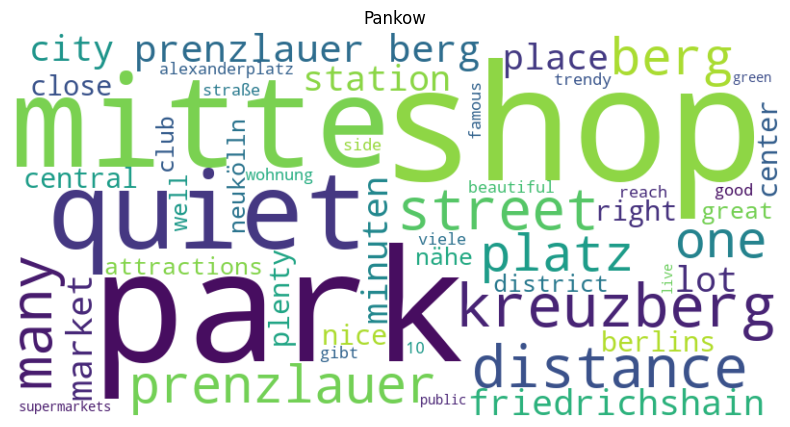

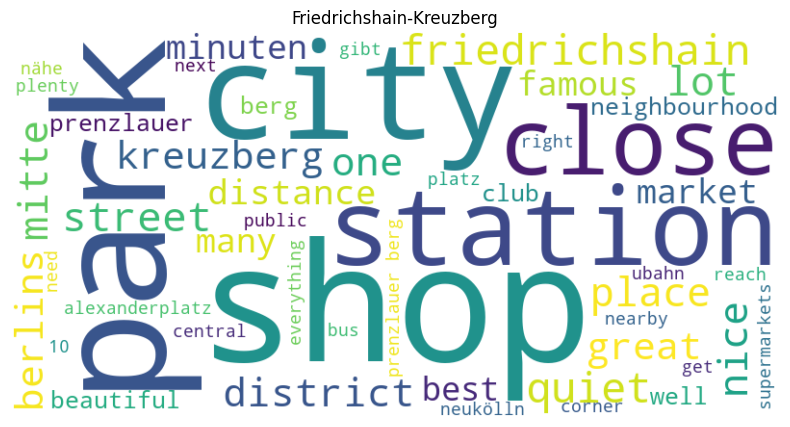

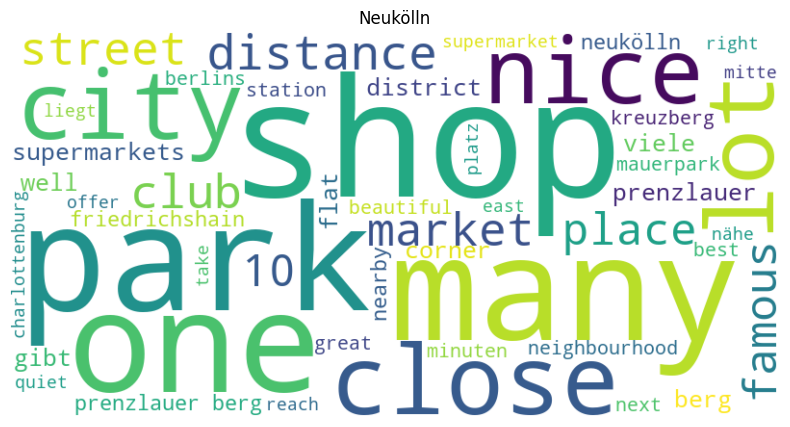

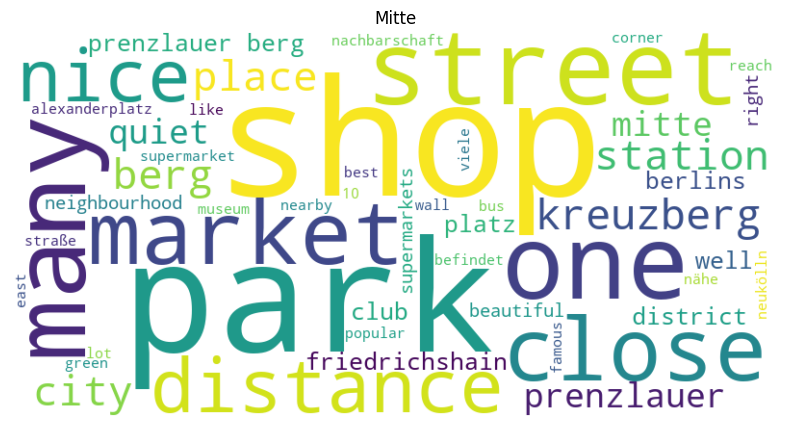

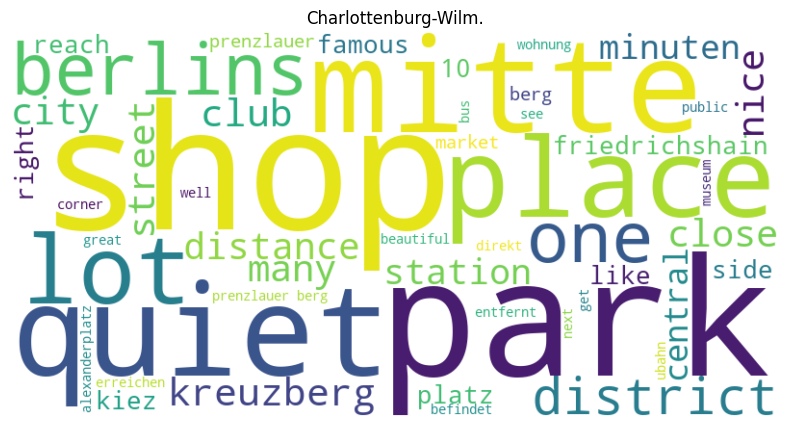

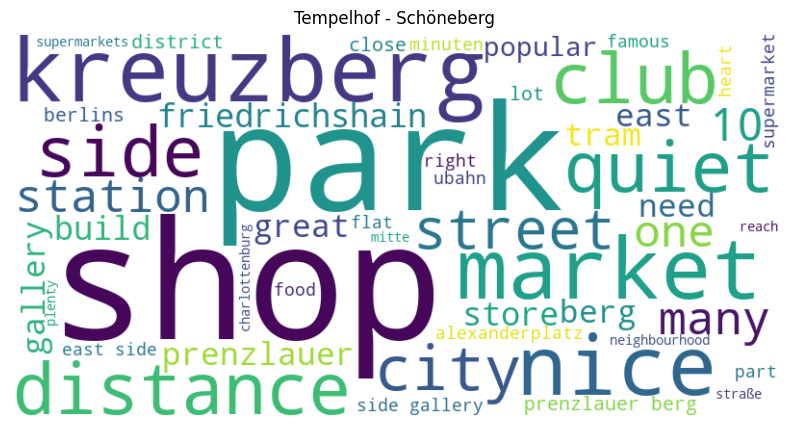

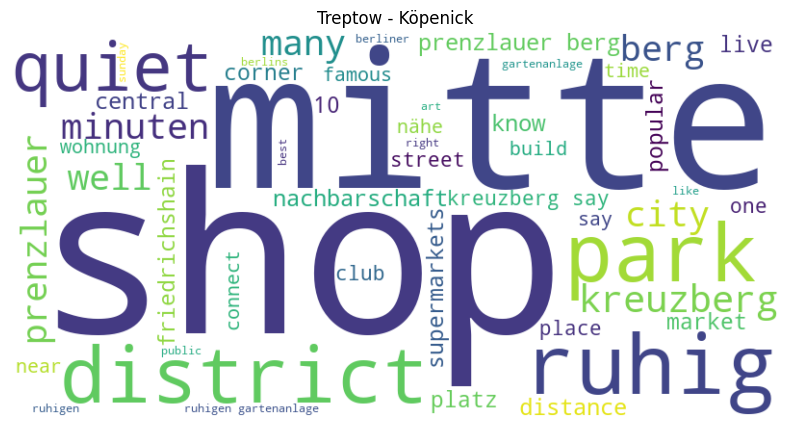

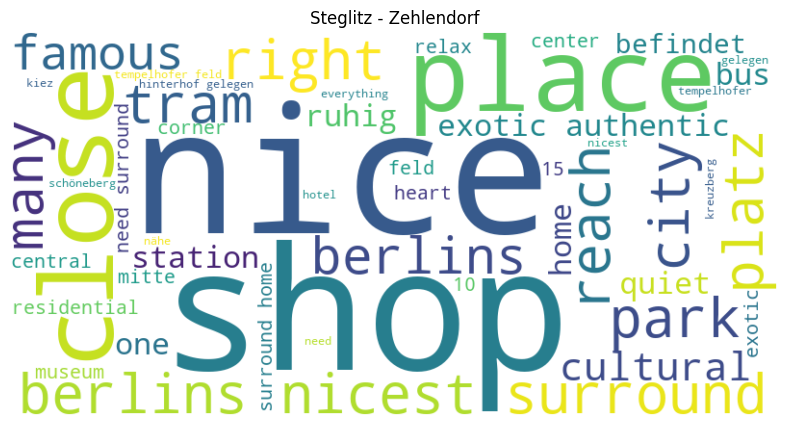

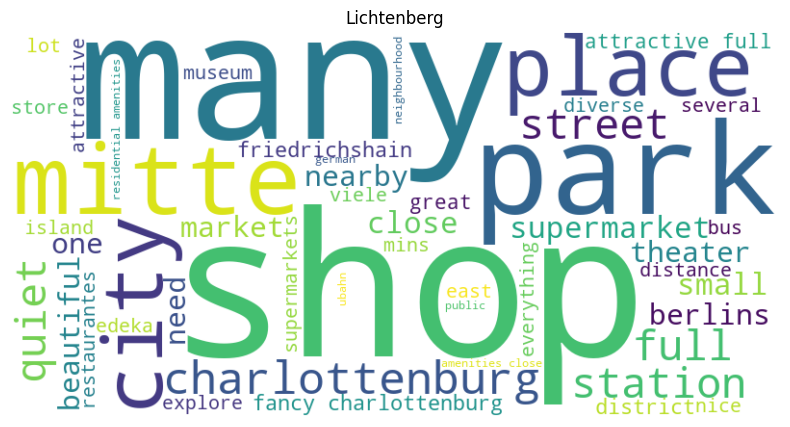

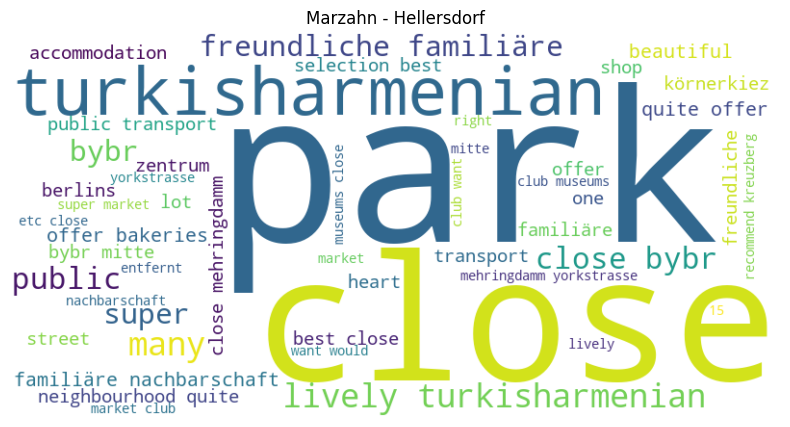

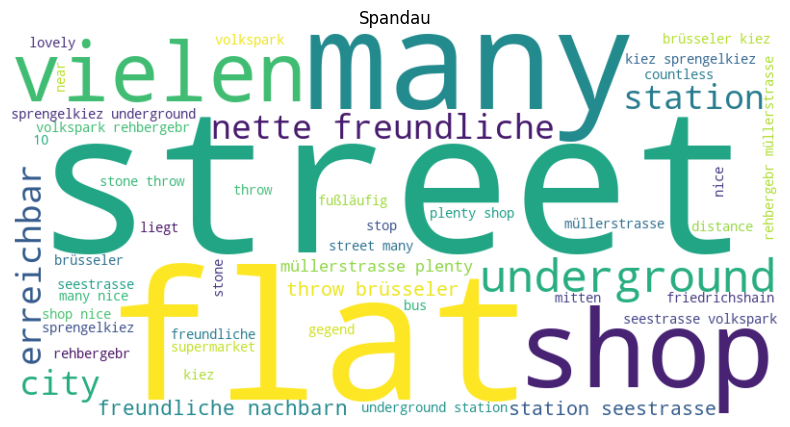

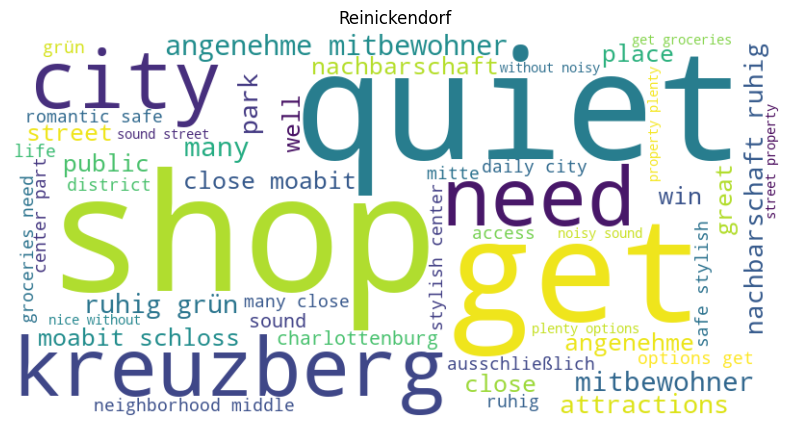

In [81]:
for specific_neighborhood in listings.neighbourhood_group_cleansed.unique():
    # get TF-IDF scores for the top 50 keywords for each neighborhood
    result_dict = neighborhood_keywords[specific_neighborhood].sort_values(ascending=False)[:50].to_dict()
    # generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(result_dict)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(specific_neighborhood)
    plt.show()




## Check the reviews for the best and the worst location: 

We select the 3 best, the 3 worst and the best and the worst scored neighborhoods based on the 'review_scores_location' column.

In [82]:


sorted_listings = listings[['neighbourhood_group_cleansed','review_scores_location']].groupby('neighbourhood_group_cleansed').mean().sort_values(by=['review_scores_location'])
worsts =sorted_listings.index[0:3]
bests = sorted_listings.index[len(sorted_listings)-3:len(sorted_listings)]

worst=sorted_listings.index[0]
best=sorted_listings.index[len(sorted_listings)-1]

print(f"Best located Neighborhood based on column 'review_scores_location': {best}.")
print(f"Worst located Neighborhood based on column 'review_scores_location': {worst}.")


Best located Neighborhood based on column 'review_scores_location': Friedrichshain-Kreuzberg.
Worst located Neighborhood based on column 'review_scores_location': Marzahn - Hellersdorf.


UNFORTUNATELY NOT ENOUGH MEMORY TO ANSWER THAT!

Here I wanted to evaluate the users' comments about the location. Unfortunately, this cannot happen due to memory problems. However, for smaller datasets (for example Boston Airbnb 2016/17) the commented out code works.

In [83]:
# specific_neighborhood = best
# top_keywords = get_top_keywords(specific_neighborhood,neighborhood_keywords_comments,top_n=20)

# # Create a WordCloud object
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_keywords)

# # Plot the WordCloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [84]:
# specific_neighborhood = worst
# top_keywords = get_top_keywords(specific_neighborhood,neighborhood_keywords_comments,top_n=20)

# # Create a WordCloud object
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_keywords)

# # Plot the WordCloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [85]:
# # get the comments of the bests and the worsts
# comments = reviews_neighborhood[reviews_neighborhood.neighbourhood_group_cleansed.isin([best])].comments
# neighborhoods_of_comments = reviews_neighborhood[reviews_neighborhood.neighbourhood_group_cleansed.isin([best])].neighbourhood_group_cleansed

# # clean the selceted comments
# clean_comments =comments.apply(preprocess_text)

# # get the keywords for the selected columns
# neighborhood_keywords_comments = get_keywords(text_vector= clean_comments, text_neighborhoods = neighborhoods_of_comments)




# How much does the price differ depending on the neighborhood?

Here we see Mean price and mean review scores for location depending on neighborhood.
There is a correlation between price and location rating. In Reinickendorg, Stieglitz-Zehlendorf and Neukölln you have a good price performance ratio.


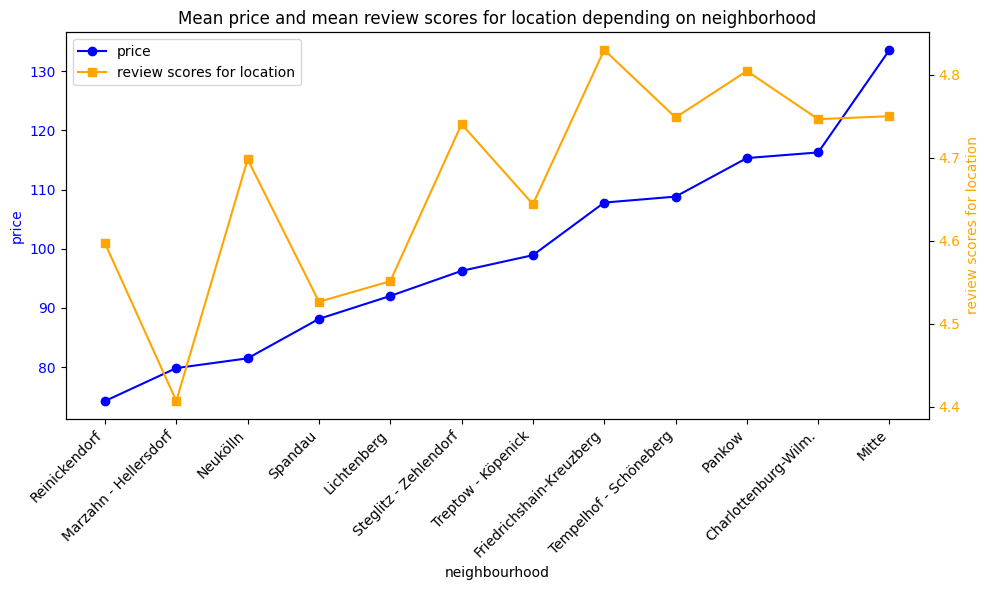

In [86]:

price_location_df = listings[["price","neighbourhood_group_cleansed","review_scores_location"]].groupby("neighbourhood_group_cleansed").mean().sort_values("price")#.sort_values("review_scores_location")
price_location_df.reset_index(inplace=True)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(price_location_df['neighbourhood_group_cleansed'], price_location_df['price'], color='blue', marker='o', label='price')
ax1.set_xlabel('neighbourhood')
ax1.set_ylabel('price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(price_location_df['neighbourhood_group_cleansed'], price_location_df['review_scores_location'], color='orange', marker='s', label='review scores for location')
ax2.set_ylabel('review scores for location', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc=0)

plt.title('Mean price and mean review scores for location depending on neighborhood')
ax1.set_xticks(price_location_df.index)
ax1.set_xticklabels(price_location_df['neighbourhood_group_cleansed'], rotation=45, ha="right")

plt.tight_layout()
plt.show()



Where do you find the most listings?


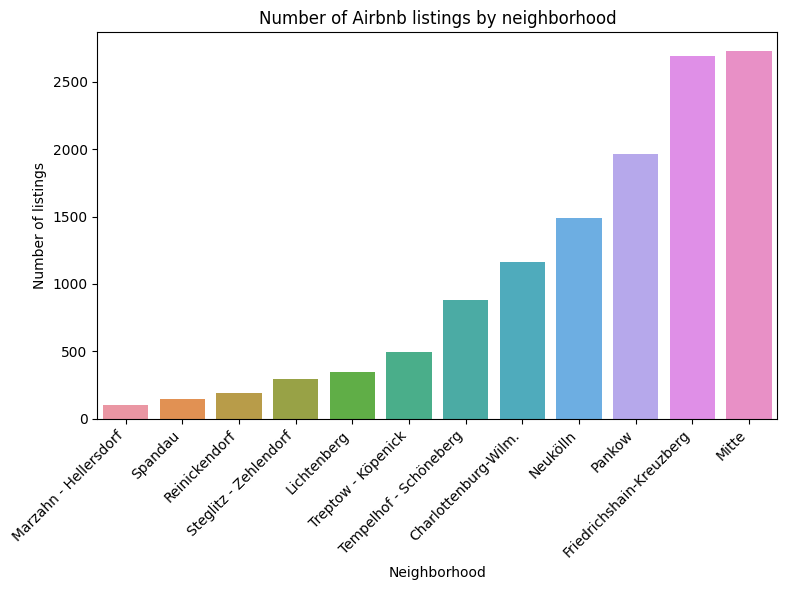

In [87]:
# listings by neighborhood

number_of_listings_per_neighborhood = listings[["neighbourhood_group_cleansed","id"]].groupby("neighbourhood_group_cleansed").count().reset_index()
number_of_listings_per_neighborhood.sort_values(by='id',inplace=True)
number_of_listings_per_neighborhood.reset_index(inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(data=number_of_listings_per_neighborhood, x='neighbourhood_group_cleansed', y='id')
plt.xlabel('Neighborhood')
plt.ylabel('Number of listings')
plt.title('Number of Airbnb listings by neighborhood')
plt.xticks(rotation=45,ha='right') 
plt.tight_layout()

plt.show()

Another representation of the average price per neighborhood.: 

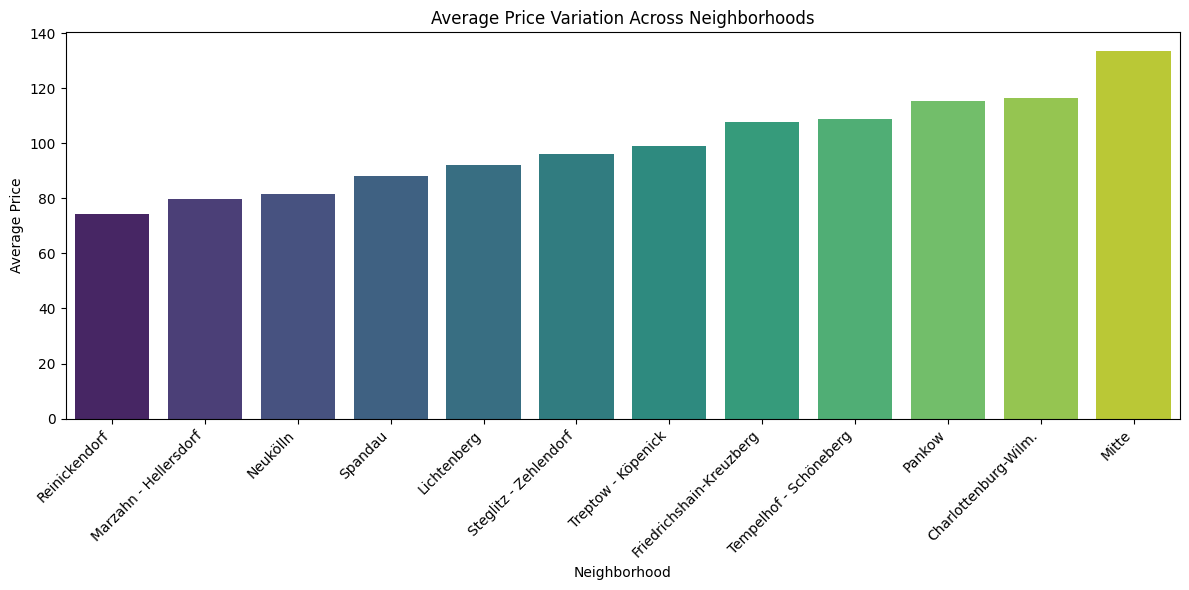

In [88]:
# prices by neighborhood

plt.figure(figsize=(12, 6))
sns.barplot(data=price_location_df, x='neighbourhood_group_cleansed', y='price', palette='viridis')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.title('Average Price Variation Across Neighborhoods')
plt.xticks(rotation=45,ha='right') 
plt.tight_layout()
plt.show()



Let's put these results together in a Map. If you move the mouse over the colored areas, the name of the neighborhood, its average price and the average score of the loaction will appear. Additionally, we see a few places of interest. Feel free to add more points of interest! All you have to do is edit the important_places.csv file. 

In [89]:
# Load the GeoJSON data and the CSV data
geojson_path = geo_path + "neighbourhoods.geojson"
gdf = gpd.read_file(geojson_path)

csv_path = geo_path + "neighbourhoods.csv"
data = pd.read_csv(csv_path)
data =data.merge(price_location_df, how="left", right_on="neighbourhood_group_cleansed", left_on="neighbourhood_group")
data = data.dropna(subset="neighbourhood_group")


# Load important places data
places_data = pd.read_csv("./important_places.csv" )


# # Merge average prices with GeoDataFrame based on neighbourhood_group
gdf = gdf.merge(data, on='neighbourhood_group', how='left')
gdf.dropna(subset=['price'], inplace=True)

# # Create a folium map
m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=11.)

# Generate colors for each neighbourhood_group
cmap = plt.get_cmap('Set3')
unique_groups = gdf['neighbourhood_group'].unique()
colors = [cmap(i) for i in range(len(unique_groups))]
# convert colors to hex
colors2 =[]
for i in colors:
    colors2.append(matplotlib.colors.rgb2hex(i))

color_map = {group: colors2[i % len(colors2)] for i, group in enumerate(unique_groups)}

# Create GeoDataFrame based on neighbourhood_group
dissolved_gdf = gdf.dissolve(by='neighbourhood_group', aggfunc='first')
dissolved_gdf = dissolved_gdf.reset_index()

# Generate colors for each neighbourhood_group
cmap = plt.get_cmap('Set3')
unique_groups = dissolved_gdf['neighbourhood_group'].unique()
colors = [cmap(i) for i in range(len(unique_groups))]

# convert colors to hex
colors2 =[]
for i in colors:
    colors2.append(matplotlib.colors.rgb2hex(i))

color_map = {group: colors2[i % len(colors2)] for i, group in enumerate(unique_groups)}

# Add GeoJSON layer to folium map for dissolved neighborhood_group boundaries with color fill
folium.GeoJson(dissolved_gdf,
               name='neighbourhood_group_fill',
               style_function=lambda feature: {
                   'fillColor': color_map[feature['properties']['neighbourhood_group']],
                   'fillOpacity': 0.7,
                   'color': 'black',  # Border color
                   'weight': 1,       # Border weight
               },tooltip=folium.GeoJsonTooltip(fields=['neighbourhood_group', 'price','review_scores_location'],
                                            aliases=['','Avg Price','Score location'],
                                              localize=True)

).add_to(m)

# Add icons with important places to the folium map

for idx, row in places_data.iterrows():
    folium.Marker([row['\tplace_latitude'], row['\tplace_longitude']],
                  icon=folium.Icon(icon='star'),
                  popup=row['place_name']).add_to(m)

# Display the folium map in the notebook
display(m)



C:\Users\franz\AppData\Local\Temp\ipykernel_22136\2446168753.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=11.)


# How do time aspects affect the price? When is it cheapest to travel?

Now, let's have a look at seasons and spikes. 
The peak in Septemmber 2023 is likely due to the Berlin Marathon (24.09.). The spike in December and January is due to New Year's Eve.
We can also guess that it is more expensive on weekends. We should investigate this further! 

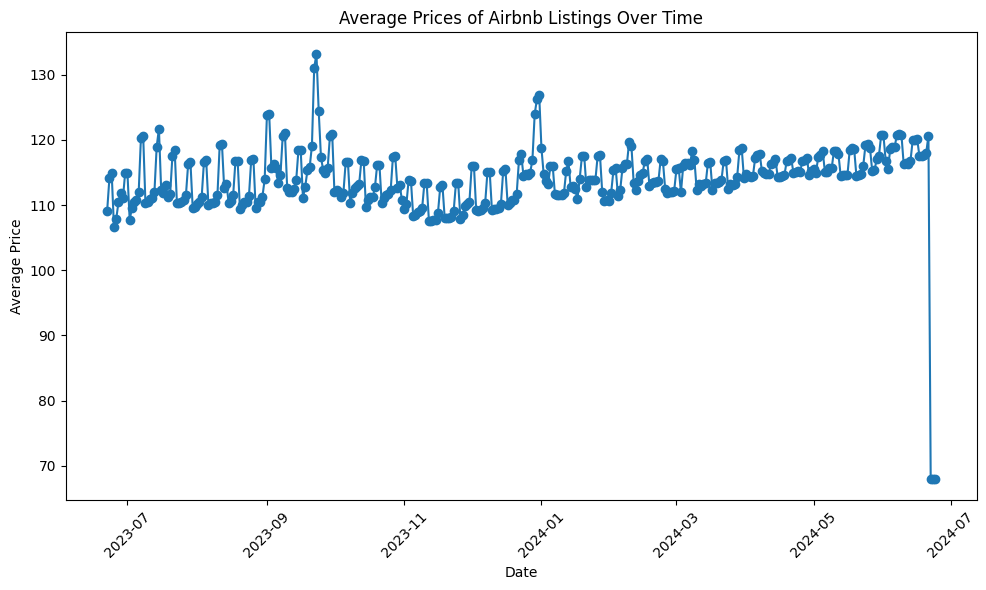

In [90]:


dates = calendar['date']
prices = calendar['price']

# calculate the mean price per year and month
mean_prices = calendar.groupby(['year', 'month'])['price'].mean().reset_index()
mean_prices_date = calendar.groupby(['date'])['price'].mean().reset_index()
mean_prices_date
#plot the results

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_date['date'], mean_prices_date['price'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Prices of Airbnb Listings Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#mean_prices_date[mean_prices_date['date']>"2023-12"].head(n=50)



## Check if the price depends on the weekday for all listings in Berlin. 

We see that it is more expensive to book an Airbnb in Berlin on Fridays and Saturdays. Next, we investigate whether this applies equally to all neighborhoods. 

<Axes: xlabel='weekday'>

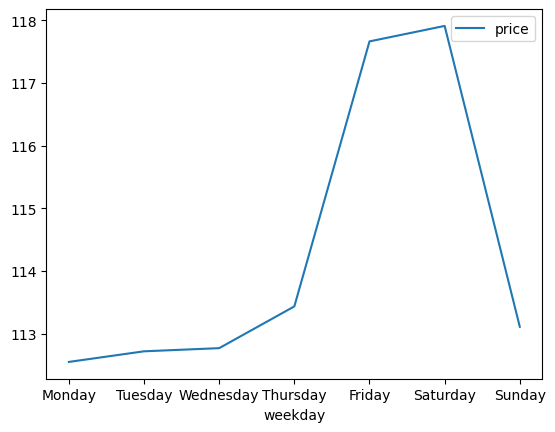

In [91]:

# get the weekday for each timestamp

calendar_neighborhood['timestamp'] = pd.to_datetime(calendar_neighborhood['date'])
calendar_neighborhood['weekday'] = calendar_neighborhood['timestamp'].dt.day_name()
calendar_neighborhood['weekday_number'] = calendar_neighborhood['timestamp'].dt.weekday

average_price_per_weekday = calendar_neighborhood[['price','weekday','weekday_number']].groupby(['weekday','weekday_number']).mean().reset_index()
average_price_per_weekday = average_price_per_weekday.sort_values(by= 'weekday_number')
average_price_per_weekday.plot(x="weekday",y="price")

The difference in price between Fridays and Saturdays and the other days depends on the neighborhood. The trend is the same, but the spread is different. The only exception is Reinickendorf. Here you do not see any price increase on weekends.

c:\Users\franz\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\franz\AppData\Local\Temp\ipykernel_22136\1865199047.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


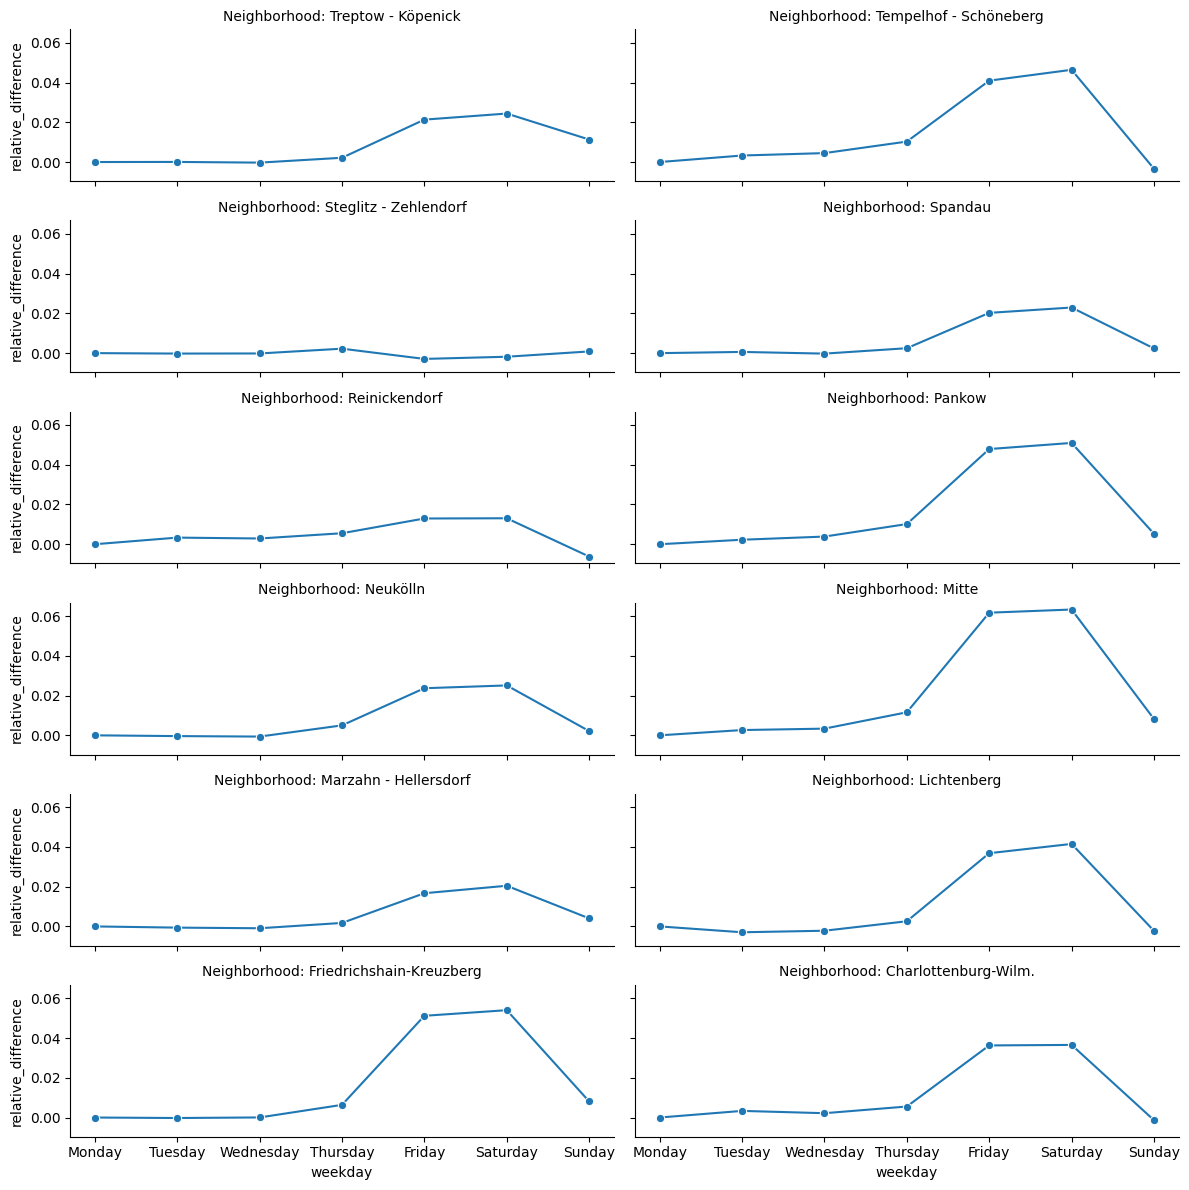

In [92]:
average_price_per_weekday = calendar_neighborhood[['price','weekday','weekday_number','neighbourhood_group_cleansed']].groupby(['weekday','weekday_number','neighbourhood_group_cleansed']).mean().reset_index()
average_price_per_weekday = average_price_per_weekday.sort_values(by= 'weekday_number')

average_price_per_weekday['relative_difference'] = average_price_per_weekday.groupby('neighbourhood_group_cleansed')['price'].transform(lambda x: x / x.iloc[0] - 1)
average_price_per_weekday

g = sns.FacetGrid(average_price_per_weekday, col='neighbourhood_group_cleansed', col_wrap=2, height=2, aspect=3)
g.map(sns.lineplot, "weekday","relative_difference", marker='o')
g.set_axis_labels('weekday', 'relative_difference')
g.set_titles('Neighborhood: {col_name}')

plt.tight_layout()
plt.show()


In [93]:
# plt.figure(figsize=(10, 6))
# sns.barplot(data=mean_prices, x='month', y='price', hue='year', palette='viridis')
# plt.xlabel('Month')
# plt.ylabel('Average Price')
# plt.title('Monthly Price Variation of Airbnb Listings')
# plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# plt.legend(title='Year')
# plt.tight_layout()
plt.show()

# What can we say about the Neighborhood Host Dynamics?

Here we first see the development for the whole of Berlin. The number of new hosts per year grows until 2015 and then collapses. We also see a slight downward bend during the Corona Pandemic 2020. 


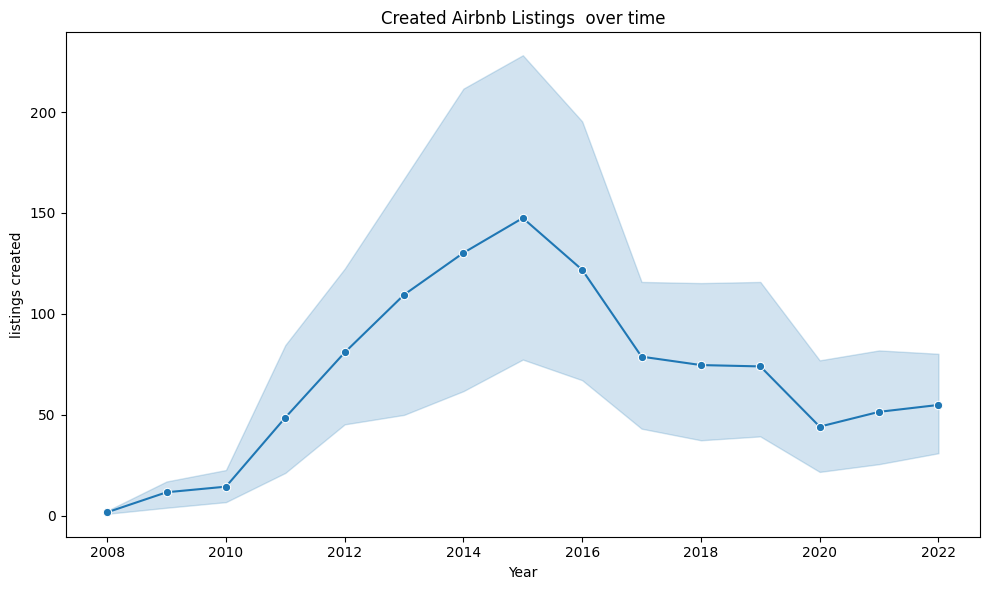

In [94]:
# check listings creation trends
listings['host_since'] = pd.to_datetime(listings['host_since'])
listings['creation_year'] = listings['host_since'].dt.year
new_listings_count = listings.groupby(['creation_year','neighbourhood_group_cleansed'])['id'].count()
new_listings_count = new_listings_count.reset_index()
new_listings_count = new_listings_count[new_listings_count.creation_year!=2023]


plt.figure(figsize=(10, 6))
sns.lineplot(data=new_listings_count, x='creation_year', y='id', marker='o')
plt.xlabel('Year')
plt.ylabel('listings created')
plt.title('Created Airbnb Listings  over time')

plt.tight_layout()
plt.show()





Let's find out what that trajectory looks like for each neighborhood.

c:\Users\franz\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\franz\AppData\Local\Temp\ipykernel_22136\1516023425.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


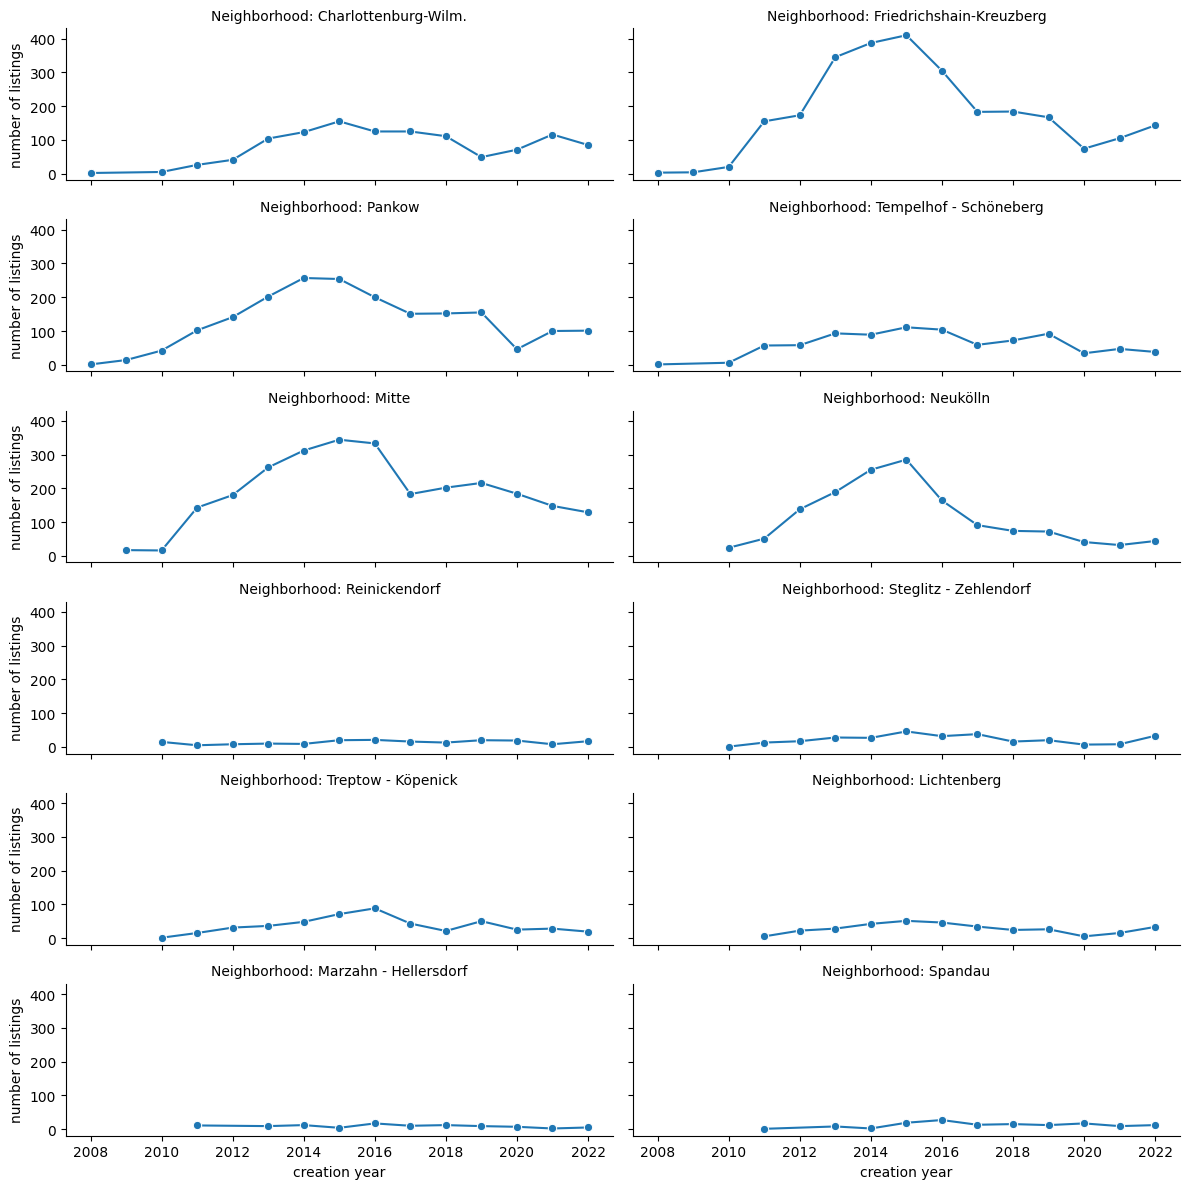

In [95]:
g = sns.FacetGrid(new_listings_count, col='neighbourhood_group_cleansed', col_wrap=2, height=2, aspect=3)
g.map(sns.lineplot, 'creation_year', 'id', marker='o')
g.set_axis_labels('creation year', 'number of listings')
g.set_titles('Neighborhood: {col_name}')

plt.tight_layout()
plt.show()



# Does the host response rate influence communication review scores?

Let's check if there is an association between host response rate and review scores communication:

The correlation is very low. 

-0.014685548116217874


Text(0.5, 1.0, 'Encoded Host Response Time vs. Average Review Score')

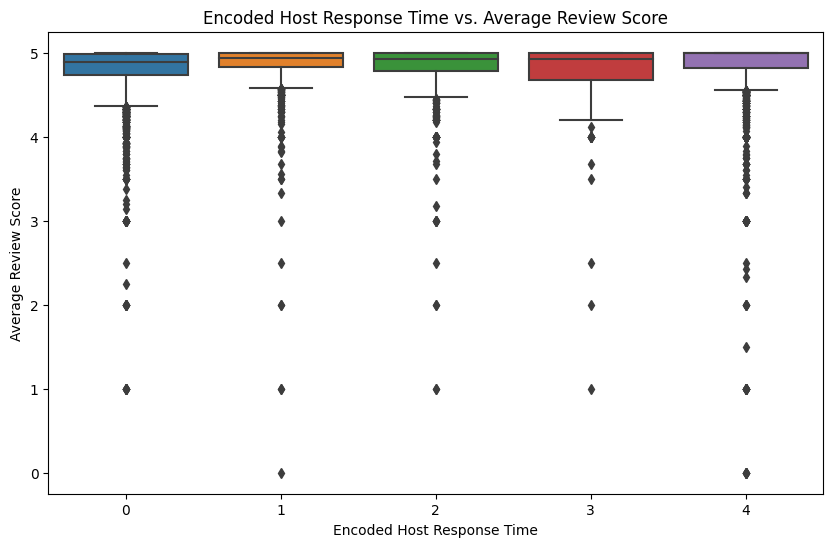

In [96]:
correlation_rate = listings['host_response_rate'].corr(listings['review_scores_communication'])
print(correlation_rate)

ordinal_categories = ['within an hour', 'within a few hours', 'within a day', 'a few days or more','unknown']
listings['host_response_time_encoded'] = listings['host_response_time'].apply(lambda x: ordinal_categories.index(x))

correlation_encoded = listings['host_response_time_encoded'].corr(listings['review_scores_communication'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='host_response_time_encoded', y='review_scores_communication', data=listings)
plt.xlabel('Encoded Host Response Time')
plt.ylabel('Average Review Score')
plt.title('Encoded Host Response Time vs. Average Review Score')


# Number of Super hosts by Neighborhood

## Which neighborhood has the most superhosts?


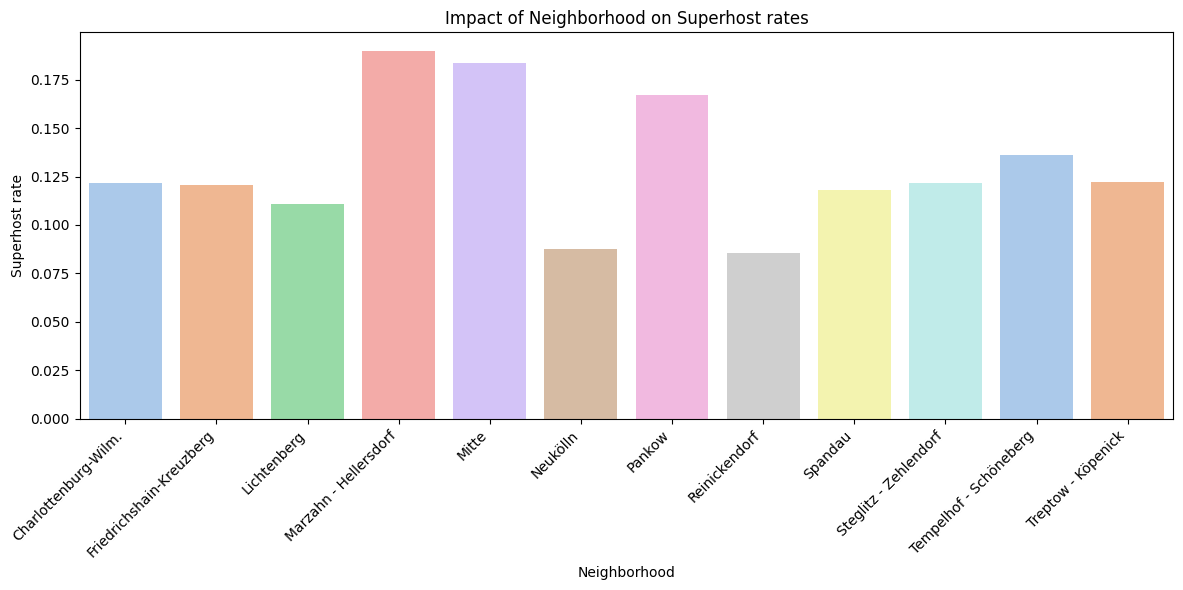

neighbourhood_group_cleansed  host_is_superhost    id  superhost_rate
0          Charlottenburg-Wilm.                141  1159        0.121657
1      Friedrichshain-Kreuzberg                325  2691        0.120773
2                   Lichtenberg                 38   343        0.110787
3         Marzahn - Hellersdorf                 19   100        0.190000
4                         Mitte                502  2731        0.183815
5                      Neukölln                130  1487        0.087424
6                        Pankow                328  1962        0.167176
7                 Reinickendorf                 16   187        0.085561
8                       Spandau                 17   144        0.118056
9         Steglitz - Zehlendorf                 36   296        0.121622
10       Tempelhof - Schöneberg                120   881        0.136209
11           Treptow - Köpenick                 60   491        0.122200

In [97]:
# number of Superhosts by Neighborhood

superhost_neighborhood = listings[listings['host_is_superhost']=="t"].groupby('neighbourhood_group_cleansed')['host_is_superhost'].count().reset_index()
listings_neighborhood = listings.groupby('neighbourhood_group_cleansed')['id'].count().reset_index()

superhost_per_neighborhood = superhost_neighborhood.merge(listings_neighborhood, how="inner", on = "neighbourhood_group_cleansed" )
superhost_per_neighborhood["superhost_rate"] = superhost_per_neighborhood.host_is_superhost / superhost_per_neighborhood.id

# Create a bar plot to compare  superhost rate over neighborhoods
plt.figure(figsize=(12, 6))
sns.barplot(data=superhost_per_neighborhood, x='neighbourhood_group_cleansed', y='superhost_rate', palette='pastel')
plt.xlabel('Neighborhood')
plt.ylabel('Superhost rate')
plt.title('Impact of Neighborhood on Superhost rates')
plt.xticks(rotation=45,ha='right') 
plt.tight_layout()
plt.show()

superhost_per_neighborhood


## Is there a relationship between the superhost ratio and the average price per neighborhood?

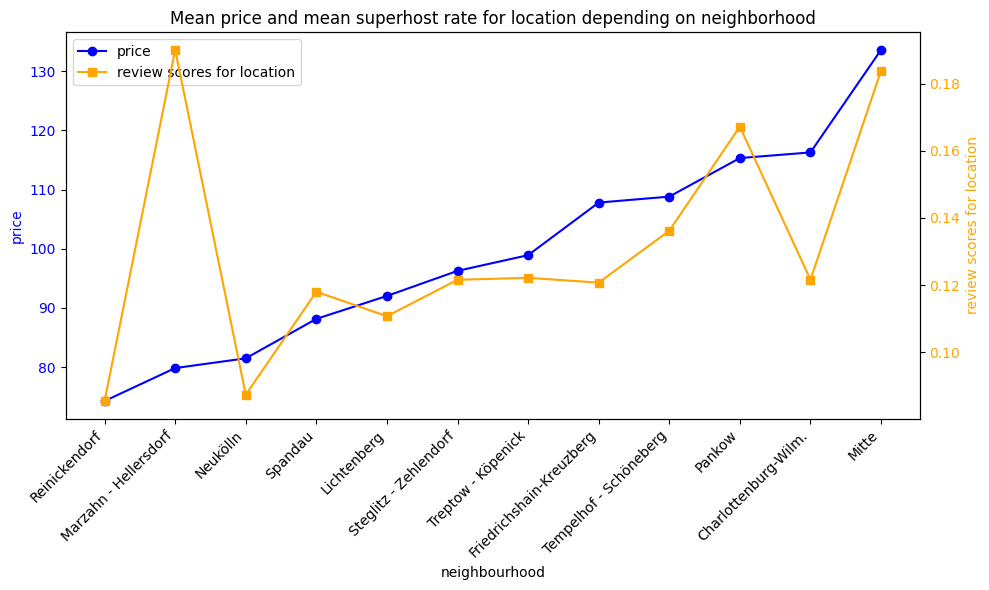

In [98]:
# # Compare the price and the superhost rate by neighborhood


# merge the price
superhost_per_neighborhood = superhost_per_neighborhood.merge(price_location_df,how="inner", on = "neighbourhood_group_cleansed" )

superhost_per_neighborhood.sort_values(by = "price", inplace=True)
superhost_per_neighborhood.reset_index(inplace=True)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(superhost_per_neighborhood['neighbourhood_group_cleansed'], superhost_per_neighborhood['price'], color='blue', marker='o', label='price')
ax1.set_xlabel('neighbourhood')
ax1.set_ylabel('price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(superhost_per_neighborhood['neighbourhood_group_cleansed'], superhost_per_neighborhood['superhost_rate'], color='orange', marker='s', label='review scores for location')
ax2.set_ylabel('review scores for location', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc=0)

plt.title('Mean price and mean superhost rate for location depending on neighborhood')
ax1.set_xticks(superhost_per_neighborhood.index)
ax1.set_xticklabels(superhost_per_neighborhood['neighbourhood_group_cleansed'], rotation=45, ha="right")

plt.tight_layout()
plt.show()



## Do the review scores differ depending on the Superhost status?

  host_is_superhost  review_scores_rating
0                 f              4.626787
1                 t              4.859463


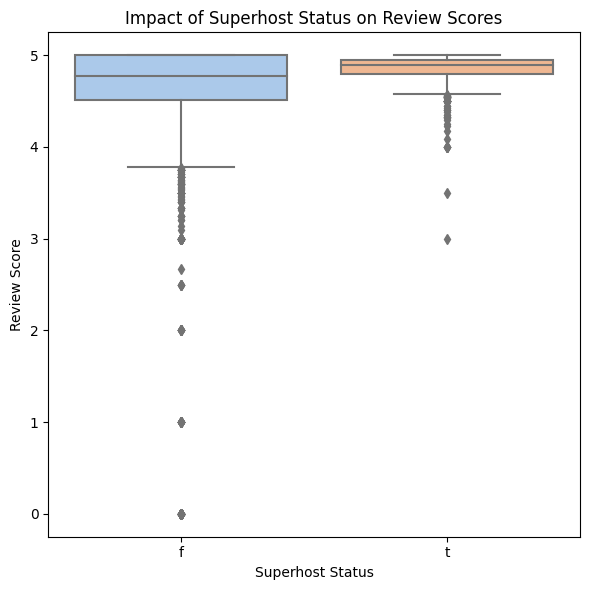

In [99]:

# # review Scores by superhost
superhost_reviews = listings.groupby('host_is_superhost')['review_scores_rating'].mean().reset_index()
print(superhost_reviews)
# Create a box plot to compare  review scores for superhost and non-superhost listings
plt.figure(figsize=(6, 6))
sns.boxplot(data=listings, x='host_is_superhost', y='review_scores_rating', palette='pastel')
plt.xlabel('Superhost Status')
plt.ylabel('Review Score')
plt.title('Impact of Superhost Status on Review Scores')
plt.tight_layout()
plt.show()

# Can we predict the price of an Airbnb in Berlin using a LightGBM? 

Since this is a complex task with probably also nonlinear correlations, I prefer a LightGBM to linear regression. 


Split data into train and test data

In [100]:
pd.set_option('display.max_columns', None)
data = listings[['host_is_superhost', 'neighbourhood_group_cleansed',
'property_type', 'room_type', 'accommodates',
'bathrooms', 'bedrooms', 'beds',  'minimum_nights',
       'maximum_nights',
 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 
        'instant_bookable',
        'calculated_host_listings_count',
       'reviews_per_month','price']]

# remove $: security_deposit	cleaning_fee extra_people
# NANs: 	square_feet-> nearly all na-> remove 
# ordinal: cancellation_policy? 

data = data.dropna(subset=['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','price'])

data.property_type = data.property_type.fillna("Unknown")
data.bathrooms =data.bathrooms.fillna(0)
data.bedrooms = data.bedrooms.fillna(0)
data.beds = data.beds.fillna(0)



# Index(['square_feet', 'security_deposit', 'cleaning_fee',
#        'review_scores_rating', 'review_scores_accuracy',
#        'review_scores_cleanliness', 'review_scores_checkin',
#        'review_scores_communication', 'review_scores_location',
#        'review_scores_value', 'reviews_per_month'],
columns_with_nan = data.columns[data.isna().any()]
columns_with_nan

categorical_features = ['host_is_superhost', 'neighbourhood_group_cleansed', 'property_type', 'room_type',  'instant_bookable']
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for feature in categorical_features:
      data[feature] = encoder.fit_transform(data[feature])



X = data.drop('price', axis=1)
y= data['price']

In [101]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Preprocess categorical data:

In [102]:
categorical_feature_indices = [X_train.columns.get_loc(feature) for feature in categorical_features]



To minimize overfitting I use early stopping and regularization.
Parameter Tuning: I perform a grid search here. 


In [103]:
from sklearn.metrics import r2_score


callbacks = [early_stopping(10)]


# Fit the model with early stopping            
train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_feature_indices)
test_dataset = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_feature_indices, reference=train_dataset)

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'num_leaves': [8, 16, 32],
    'learning_rate': [0.05,0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150, 200]
}

# Initialize variables to track best hyperparameters and performance
best_params = {}
best_rmse = float('inf')
best_r2 = 0
# Loop through hyperparameter combinations
for num_leaves in param_grid['num_leaves']:
    for learning_rate in param_grid['learning_rate']:
        for n_estimators in param_grid['n_estimators']:
            
            # Create the model with current hyperparameters
            model = lgb.LGBMRegressor(
                objective='regression',
                num_leaves=num_leaves,
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                reg_alpha=0.9,
                reg_lambda=0.9            )

            # Fit the model with early stopping
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=callbacks)

            # Predict using the trained model
            y_pred = model.predict(X_test)
            
            # Calculate RMSE (Root Mean Squared Error) on validation data
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            # Calculate R-squared value
            r2 = r2_score(y_test, y_pred)

            # Update best hyperparameters if RMSE improves
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'n_estimators': n_estimators
                }
                best_model = model

  

print("Best Hyperparameters:", best_params)
print("Best Validation RMSE:", best_rmse)
print("Best Validation RMSE:", best_r2)





Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's l2: 3899.2
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 3485.64
Did not meet early stopping. Best iteration is:
[150]	valid_0's l2: 3362.02
Did not meet early stopping. Best iteration is:
[195]	valid_0's l2: 3307.52
Did not meet early stopping. Best iteration is:
[195]	valid_0's l2: 3307.52
Did not meet early stopping. Best iteration is:
[195]	valid_0's l2: 3307.52
Did not meet early stopping. Best iteration is:
[195]	valid_0's l2: 3307.52
Did not meet early stopping. Best iteration is:
[195]	valid_0's l2: 3307.52
Did not meet early stopping. Best iteration is:
[195]	valid_0's l2: 3307.52
Did not meet early stopping. Best iteration is:
[195]	valid_0's l2: 3307.52
Did not meet early stopping. Best iteration is:
[195]	valid_0's l2: 3307.52
Did not meet early stopping. Best iteration is:
[195]	valid_0's l2: 3307.52
Did not meet early stopping. 

Train RMSE: 45.78
Test RMSE: 55.99
Test RMSE is higher than Train RMSE. Possible overfitting.
Most important variables: 


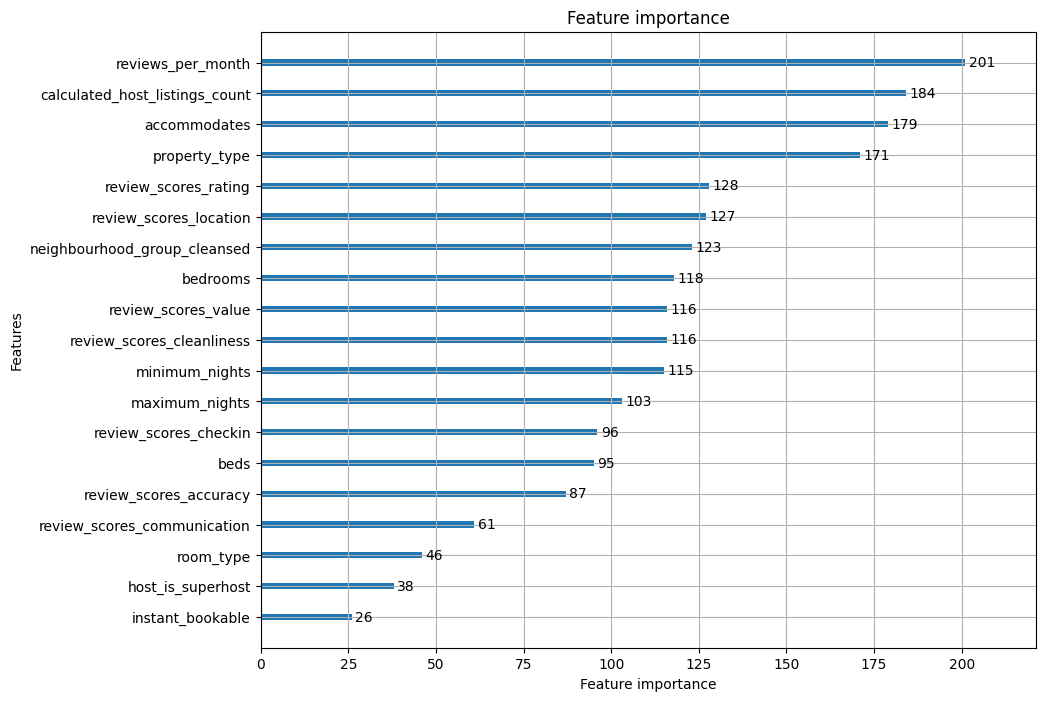

In [104]:
# Predict using the trained model on both train and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
# Calculate RMSE (Root Mean Squared Error) for both train and test sets
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Compare train RMSE and test RMSE
if test_rmse > train_rmse:
    print("Test RMSE is higher than Train RMSE. Possible overfitting.")
else:
    print("Test RMSE is similar to or lower than Train RMSE. Good generalization.")


print("Most important variables: ")

# Plot variable importance
lgb.plot_importance(best_model, importance_type='split', figsize=(10, 8))
plt.show()

# Gains table
gains_table = best_model.booster_.feature_importance(importance_type='split')

gains_df = pd.DataFrame({'Feature': X.columns, 'Gain': gains_table})



